In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

/Users/harshitsrivastava/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Text(0.5, 1.0, 'Amazon')

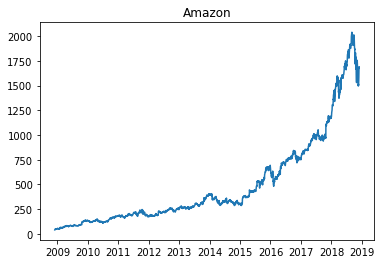

In [2]:
amzn = pd.read_csv("/Users/harshitsrivastava/Desktop/Data/Stocks/Amazon_10yr_history.csv")
amzn.loc[:,'date'] = pd.to_datetime(amzn.loc[:,'date'],infer_datetime_format=True)
plt.plot(amzn.date, amzn.close)
plt.title("Amazon")

Text(0.5, 1.0, 'Google')

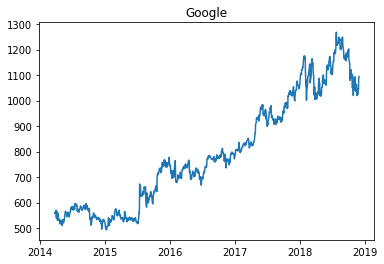

In [3]:
googl = pd.read_csv("/Users/harshitsrivastava/Desktop/Data/Stocks/Google_10yr_history.csv")
googl.loc[:,'date'] = pd.to_datetime(googl.loc[:,'date'],infer_datetime_format=True)
plt.plot(googl.date, googl.close)
plt.title("Google")

Text(0.5, 1.0, 'Goldman Sachs')

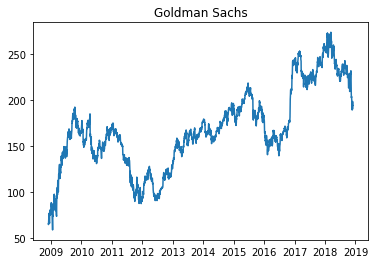

In [4]:
gold = pd.read_csv("/Users/harshitsrivastava/Desktop/Data/Stocks/Goldman_10yr_history.csv")
gold.loc[:,'date'] = pd.to_datetime(gold.loc[:,'date'],infer_datetime_format=True)
plt.plot(gold.date, gold.close)
plt.title("Goldman Sachs")

Text(0.5, 1.0, 'Accenture')

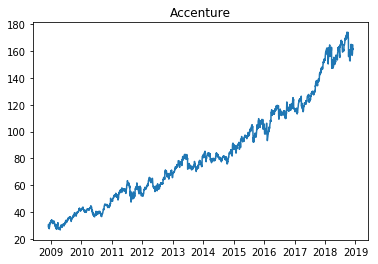

In [5]:
acn = pd.read_csv("/Users/harshitsrivastava/Desktop/Data/Stocks/Accenture_10yr_history.csv")
acn.loc[:,'date'] = pd.to_datetime(acn.loc[:,'date'],infer_datetime_format=True)
plt.plot(acn.date, acn.close)
plt.title("Accenture")

# Using stock price history of Goldman Sachs

## Cleaning, scaling and splitting into train and test

In [6]:
def prep_data(data):
    scaler = MinMaxScaler()
    data['close'] = scaler.fit_transform(data['close'].values.reshape(-1, 1))
    train = data[data['date'] <= '2017-01-01 00:00:00']
    test = data[data['date'] >= '2017-01-01 00:00:00']
    return train, test, scaler
train, test, scaler = prep_data(gold)

## Data generator

In [7]:
def create_dataset(dataset, window_size = 22):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        data_X.append(dataset[i:(i + window_size), 1])
        data_Y.append(dataset[i + window_size, 1])
        
    data_X = np.array(data_X)
    data_Y = np.array(data_Y)

    x = np.reshape(data_X, (data_X.shape[0], 1, data_X.shape[1]))
    y = np.reshape(data_Y, (data_Y.shape[0], 1, 1))
    return x, y

x_train, y_train = create_dataset(train.values)
x_test, y_test= create_dataset(test.values)

## Model

In [8]:
def lstm_model(x, window_size = 22, num_out=1):
    inputs = keras.layers.Input(shape=(1, window_size))
    x = keras.layers.LSTM(22,return_sequences=True) (inputs)
    x = keras.layers.Dropout(0.5) (x)
    x = keras.layers.LSTM(22,return_sequences=True) (x)
    x = keras.layers.Dropout(0.5) (x)
    x = keras.layers.LSTM(22,return_sequences=True) (x)
    x = keras.layers.Dropout(0.5) (x)
    #x = keras.layers.Flatten() (x)
    x = keras.layers.Dense(8) (x)
    x = keras.layers.Activation('relu') (x)
    out = keras.layers.Dense(num_out) (x)
    #out = keras.layers.Activation('linear') (out)
    model = keras.Model(inputs=inputs, outputs=out)
    print (model.summary())
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics = ['mse'])
    return model
model = lstm_model(x_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 22)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 22)             3960      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 22)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 22)             3960      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 22)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 22)             3960      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 22)             0         
__________

In [9]:
model.fit(x=x_train, y=y_train, batch_size=8, epochs=25)

Epoch 1/25
2013/2013 [==============================] - 4s 2ms/step - loss: 0.0416 - mean_squared_error: 0.0416
Epoch 2/25
2013/2013 [==============================] - 2s 1ms/step - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 3/25
2013/2013 [==============================] - 2s 1ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 4/25
2013/2013 [==============================] - 2s 952us/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 5/25
2013/2013 [==============================] - 2s 922us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 6/25
2013/2013 [==============================] - 2s 931us/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 7/25
2013/2013 [==============================] - 2s 1ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 8/25
2013/2013 [==============================] - 2s 997us/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 9/25
2013/2013 [==============================] - 2s 1ms/step - loss: 0.0025 - mean_square

In [10]:
def predict(train, x_train):
    preds = []
    train.reset_index(drop=True, inplace=True)
    for i in range(len(x_train)):
        data = np.reshape(x_train[i], (1, 1, 22))
        preds.append(model.predict(x=data, batch_size=8)[0][0][0])
        #train.loc[i+22,'Predicted'] = model.predict(x=data, batch_size=8)[0][0][0]

    predictions = np.copy(scaler.inverse_transform(np.array(preds).reshape(-1, 1)))
    train.loc[23:,'Predictions'] = np.copy(predictions)
    train.loc[:,'close'] = np.copy(scaler.inverse_transform(train.loc[:,'close'].values.reshape(-1, 1)))
    return train

train = predict(train, x_train)

/Users/harshitsrivastava/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/harshitsrivastava/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/harshitsrivastava/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

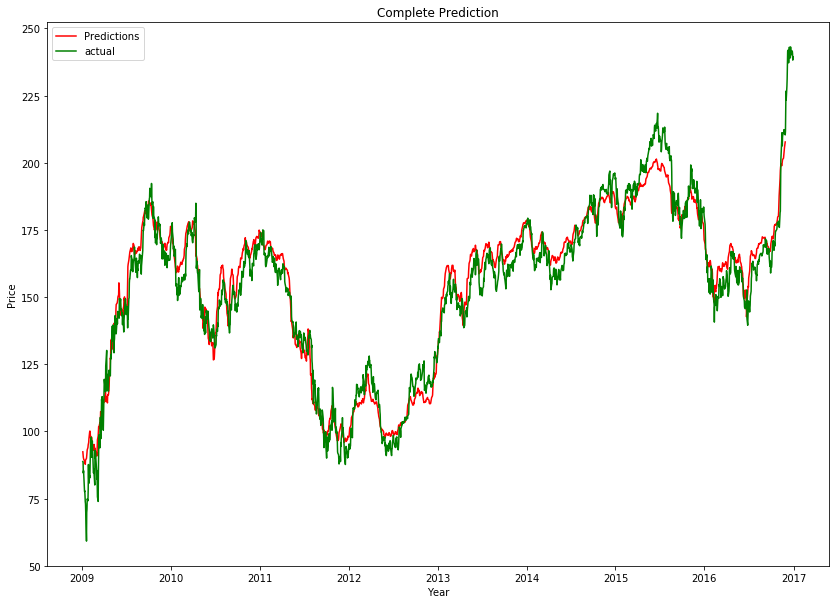

In [11]:
def plot_predictions(train, title, idx1=0, idx2=len(x_train)):
    plt.figure(figsize=(14, 10))
    plt.plot(train.date[idx1:idx2], train.Predictions[idx1:idx2], label='Predictions', color='red')
    plt.plot(train.date[idx1:idx2], train.close[idx1:idx2], label='actual', color='green')
    plt.xlabel("Year")
    plt.ylabel("Price")
    plt.title(title)
    plt.legend()
    plt.show()
    
title = "Complete Prediction"
plot_predictions(train, title)

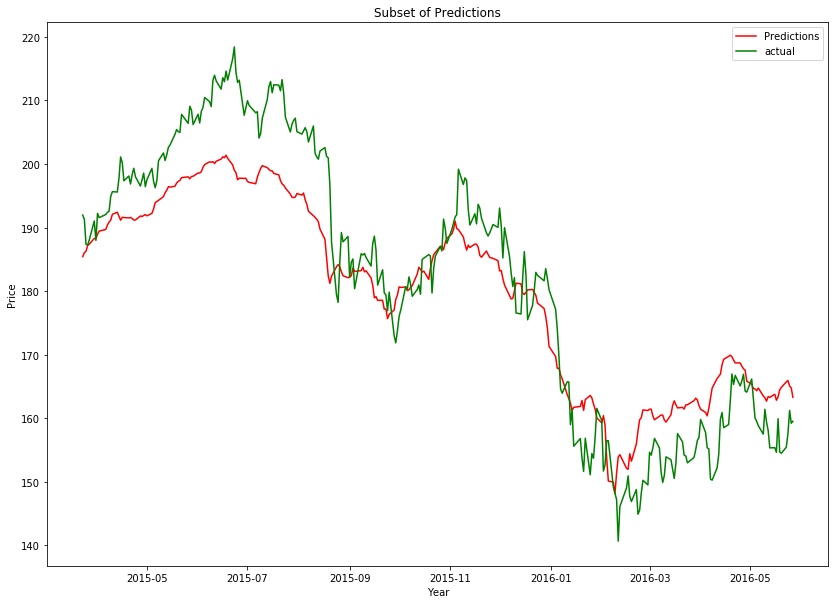

In [12]:
title = "Subset of Predictions"
plot_predictions(train, title, 150, 450)